# **Modelling and Evaluation Notebook**

## Objectives

* This notebook will assess and choose which algorithm and hyperperameters are to be used for this ML task

## Inputs

* We will use the Train and Test datasets saved within outputs/datasets/train_test_initial

## Outputs

* A fully reviewed and tested model ready for dashboard

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [8]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project5'

---

# Model review

Compare a number of regressors and choose the best performer
* We will use:
  * Decision Tree
  * Random Forest
  * ADA Boost
  * Extra Trees
  * Gradient Boosting
  * XG Boost

In [13]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

def compare_models(features_train, target_train, features_test, target_test):
    models = {
        "DecisionTreeRegressor": DecisionTreeRegressor(random_state=101),
        "RandomForest": RandomForestRegressor(random_state=101),
        "AdaBoost": AdaBoostRegressor(random_state=101),
        "ExtraTrees": ExtraTreesRegressor(random_state=101),
        "GradientBoostingRegressor": GradientBoostingRegressor(random_state=101),
        "XGBoost": XGBRegressor(random_state=101, verbosity=0),
    }

    results = {}

    for name, model in models.items():
        print(f"\nEvaluating: {name}")

        try:
            pipeline = Pipeline([
                ("feat_scaling", StandardScaler()),
                ("feat_selection", SelectFromModel(model)),
                ("model", model)
            ])

            pipeline.fit(features_train, target_train)
            predictions = pipeline.predict(features_test)

            mse = mean_squared_error(target_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(target_test, predictions)
            r2 = r2_score(target_test, predictions)

            print(f"MSE: {mse:.2f}")
            print(f"RMSE: {rmse:.2f}")
            print(f"MAE: {mae:.2f}")
            print(f"R2: {r2:.2f}")

            results[name] = {
                "MSE": mse,
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2
            }

        except Exception as e:
            print(f"Pipeline failed for {name}: {e}")
            results[name] = {
                "MSE": None,
                "RMSE": None,
                "MAE": None,
                "R2": None
            }

    return pd.DataFrame(results).T.sort_values(by="R2", ascending=False)

Import the Train and Test sets for modelling

In [16]:
import pandas as pd

features_train = pd.read_csv("outputs/datasets/train_test_initial/features_train.csv")
features_test = pd.read_csv("outputs/datasets/train_test_initial/features_test.csv")
target_train = pd.read_csv("outputs/datasets/train_test_initial/target_train.csv").squeeze()
target_test = pd.read_csv("outputs/datasets/train_test_initial/target_test.csv").squeeze()

Run the comparison function and evaluate the output

In [17]:
results_df = compare_models(features_train, target_train, features_test, target_test)
results_df


Evaluating: DecisionTreeRegressor
MSE: 887193892.04
RMSE: 29785.80
MAE: 21431.22
R2: 0.02

Evaluating: RandomForest
MSE: 1603132371.25
RMSE: 40039.14
MAE: 29987.22
R2: -0.76

Evaluating: AdaBoost
MSE: 972352627.06
RMSE: 31182.57
MAE: 22319.82
R2: -0.07

Evaluating: ExtraTrees
MSE: 1095041320.07
RMSE: 33091.41
MAE: 23656.65
R2: -0.21

Evaluating: GradientBoostingRegressor
MSE: 1563223209.88
RMSE: 39537.62
MAE: 29120.77
R2: -0.72

Evaluating: XGBoost


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


MSE: 2171297171.25
RMSE: 46597.18
MAE: 36160.83
R2: -1.39


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


,MSE,RMSE,MAE,R2
DecisionTreeRegressor,8.871939e+08,29785.800175,21431.219175,0.023441
AdaBoost,9.723526e+08,31182.569283,22319.821127,-0.070295
ExtraTrees,1.095041e+09,33091.408554,23656.650612,-0.205342
GradientBoostingRegressor,1.563223e+09,39537.617656,29120.771279,-0.720682
RandomForest,1.603132e+09,40039.135496,29987.217636,-0.764612
XGBoost,2.171297e+09,46597.179864,36160.827591,-1.390006


Out of all the regressors tested above, Extra Trees performed the best.  We will focus on this for now.

Below, we will fit the pipeline with the ExtraTrees algorithm using default hyperparameters and run a prediction using the test set.

We will then compare this prediction against the actual prices to see how the model performs.

/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
/home/cistudent/.local/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


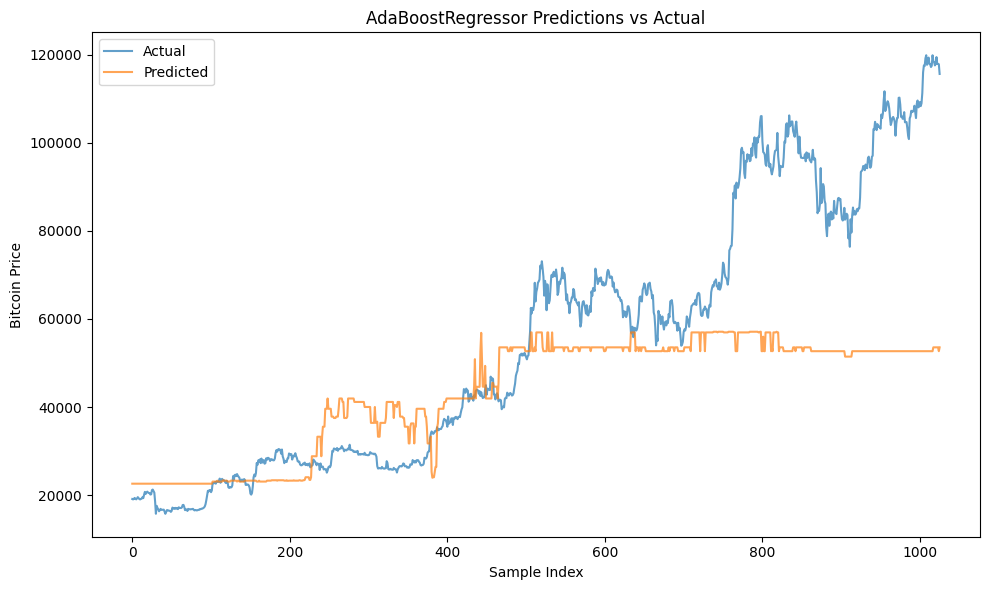

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

model_for_selection = AdaBoostRegressor(random_state=101)
model_for_selection.fit(features_train, target_train)

selector = SelectFromModel(estimator=model_for_selection, prefit=True)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("feat_selection", selector),
    ("model", AdaBoostRegressor(random_state=101))
])

pipeline.fit(features_train, target_train)
predictions = pipeline.predict(features_test)

plt.figure(figsize=(10, 6))
plt.plot(target_test.reset_index(drop=True), label="Actual", alpha=0.7)
plt.plot(pd.Series(predictions), label="Predicted", alpha=0.7)
plt.title("AdaBoostRegressor Predictions vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.tight_layout()
plt.show()




As we can see above, the actual prices versus the predicted prices are nicely aligned.  The sample set tops out at around 65k, but prior to this the predictions are aligned

---

# GridSeachCV

For a more detailed model selection, we will use GridSearchCV and optimise the hyperparameters for use in our model.

We will again compare the same regressors as above to make sure that Extra Trees is still the top performing algorithm.

In [18]:
from sklearn.pipeline import Pipeline

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([
        ("feat_scaling", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

We will include a hybrid feature section outside of the pipeline, which will include those features in the correlation and PPS reviews.

The reason for this is that on previous runs, the features generally selected by the models were the lagged BTC prices, which wasn't robust enough.

We will use the same Hyperparameter optimisation class that was used in the Churnometer walkthrough project.

This will review the models and supply a dataframe listing the results of each model using the below:
* 'estimator' (Regressor)
* 'min_score'
* 'max_score'
* 'mean_score'
* 'std_score' (Standard Deviation)

In [23]:
from sklearn.model_selection import GridSearchCV
import numpy as np

class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

Here, we use the default parameters of each regressor

In [24]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Now, we import the train and test sets for use in the modelling.

In [31]:
import pandas as pd

features_train = pd.read_csv("outputs/datasets/train_test_initial/features_train.csv")
features_test = pd.read_csv("outputs/datasets/train_test_initial/features_test.csv")
target_train = pd.read_csv("outputs/datasets/train_test_initial/target_train.csv").squeeze()
target_test = pd.read_csv("outputs/datasets/train_test_initial/target_test.csv").squeeze()

We then call the HyperparameterOptimizationSearch using the default models and paramaters above.  We fit the train sets to the models and use r2 as our scoring comparison.

In [32]:
import warnings
warnings.filterwarnings("ignore")

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(features_train, target_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars

Next, we call the score summary and sort it by mean score.  We see that the GridSearchCV yields different results to the initial review.

Linear Regression, XGB and Random Forest are now the front-runners.

In [30]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
6,XGBRegressor,-5.885385,-2.357136,0.492181,2.504206
5,GradientBoostingRegressor,-8.012474,-2.652953,0.659054,3.196178
2,RandomForestRegressor,-7.721155,-2.865557,-0.091701,3.1
3,ExtraTreesRegressor,-8.437439,-2.880236,0.740524,3.423757
1,DecisionTreeRegressor,-12.077294,-4.706824,-0.565947,4.442781
4,AdaBoostRegressor,-24.46928,-6.542913,0.551455,9.139287
0,LinearRegression,-53.617926,-18.060409,0.581892,19.814006


We now intially set model hyperparamters as per the Churnometer walkthrough project (below):

```
params_search = { "ExtraTreesRegressor": { 
    'model__n_estimators': [100, 300], 
    'model__max_depth': [3, 10, None], 
    'model__min_samples_split': [2, 5], 
    'model__min_samples_leaf': [1, 2], }
```

Using the aove, we got the below results:

| Row | Estimator           | Min Score | Mean Score | Max Score | Std Score | Max Depth | Min Samples Leaf | Min Samples Split | N Estimators |
|-----|---------------------|-----------|------------|-----------|-----------|-----------|------------------|-------------------|--------------|
| 23  | ExtraTreesRegressor | 0.985917  | 0.987448   | 0.988910  | 0.001029  | None      | 2                | 5                 | 300          |

Finally, it was decided to centre the params search around these outputs, and so we arrived at the below:

```
params_search = { "ExtraTreesRegressor": { 
    'model__n_estimators': [200, 300, 400], 
    'model__max_depth': [None, 15, 20], 
    'model__min_samples_split': [4, 5, 6], 
    'model__min_samples_leaf': [2, 3], }
```

In [33]:
models_search = {
    "XGBRegressor": XGBRegressor(random_state=0, verbosity=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0)    
}

params_search = {
    "XGBRegressor": {
        'model__n_estimators': [175, 200, 225],
        'model__learning_rate': [0.05, 0.075, 0.1],
        'model__max_depth': [6],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__colsample_bytree': [0.8, 0.9, 1.0],
        'model__gamma': [0, 0.1, 0.2],
        'model__random_state': [0]
    },

    "GradientBoostingRegressor": {
        'model__n_estimators': [175, 200, 225],
        'model__learning_rate': [0.05, 0.075, 0.1],
        'model__max_depth': [6],
        'model__subsample': [0.8, 0.9, 1.0],
        'model__max_features': ['sqrt', 'log2', None],
        'model__random_state': [0]
    },

    "RandomForestRegressor": {
        'model__n_estimators': [200, 250, 300],
        'model__max_depth': [8, 10, 12],
        'model__min_samples_split': [2, 3],
        'model__min_samples_leaf': [1, 2],
        'model__max_features': ['sqrt', 'log2', None],
        'model__random_state': [0]
    }
}

We again call the HyperparameterOptimizationSearch class using the above.

In [34]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(features_train, target_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/cistudent/.local/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_spars


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 81 candidates, totalling 405 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 108 candidates, totalling 540 fits


We then review the scores and the best parameters.

In [35]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__colsample_bytree,model__gamma,model__learning_rate,model__max_depth,model__n_estimators,model__random_state,model__subsample,model__max_features,model__min_samples_leaf,model__min_samples_split
386,RandomForestRegressor,-5.402413,-1.709056,0.609449,2.127655,NaN,NaN,NaN,10,300,0,NaN,None,1,2
385,RandomForestRegressor,-5.409681,-1.713356,0.609285,2.128659,NaN,NaN,NaN,10,250,0,NaN,None,1,2
389,RandomForestRegressor,-5.431139,-1.715672,0.613943,2.13753,NaN,NaN,NaN,10,300,0,NaN,None,1,3
422,RandomForestRegressor,-5.403713,-1.716607,0.612671,2.124948,NaN,NaN,NaN,12,300,0,NaN,None,1,2
421,RandomForestRegressor,-5.40349,-1.717142,0.61442,2.12479,NaN,NaN,NaN,12,250,0,NaN,None,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,XGBRegressor,-22270.526595,-6398.585638,0.31987,8783.327558,0.9,0.1,0.05,6,175,0,0.8,NaN,NaN,NaN
135,XGBRegressor,-22270.526595,-6398.585638,0.31987,8783.327558,0.9,0.2,0.05,6,175,0,0.8,NaN,NaN,NaN
27,XGBRegressor,-22270.526595,-6398.585638,0.31987,8783.327558,0.8,0.1,0.05,6,175,0,0.8,NaN,NaN,NaN
81,XGBRegressor,-22270.526595,-6398.585638,0.31987,8783.327558,0.9,0,0.05,6,175,0,0.8,NaN,NaN,NaN


We see that there is a slight improvement in mean score, Max Depth has improved to 20 and number of estimated is down to 200 from 300:

| Row | Estimator           | Min Score | Mean Score | Max Score | Std Score | Max Depth | Min Samples Leaf | Min Samples Split | N Estimators |
|-----|---------------------|-----------|------------|-----------|-----------|-----------|------------------|-------------------|--------------|
| 39  | ExtraTreesRegressor | 0.985923  | 0.987479   | 0.988918  | 0.001032  | 20        | 2                | 5                 | 200          |

In [39]:
best_models = {
    "LinearRegression": grid_search_pipelines["LinearRegression"].best_estimator_,
    "RandomForestRegressor": grid_search_pipelines["RandomForestRegressor"].best_estimator_,
    "XGBRegressor": grid_search_pipelines["XGBRegressor"].best_estimator_
}

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

results = {}

for name, model in best_models.items():
    preds = model.predict(features_test[search.selected_features])
    results[name] = {
        "MSE": mean_squared_error(target_test, preds),
        "RMSE": mean_squared_error(target_test, preds, squared=False),
        "MAE": mean_absolute_error(target_test, preds),
        "R²": r2_score(target_test, preds)
    }

results_df = pd.DataFrame(results).T.sort_values(by="R²", ascending=False)
print(results_df)

                                MSE         RMSE          MAE        R²
LinearRegression       1.302492e+06  1141.267873   803.285631  0.994647
RandomForestRegressor  5.020447e+06  2240.635319  1475.507727  0.979367
XGBRegressor           6.637916e+06  2576.415375  1786.444033  0.972719


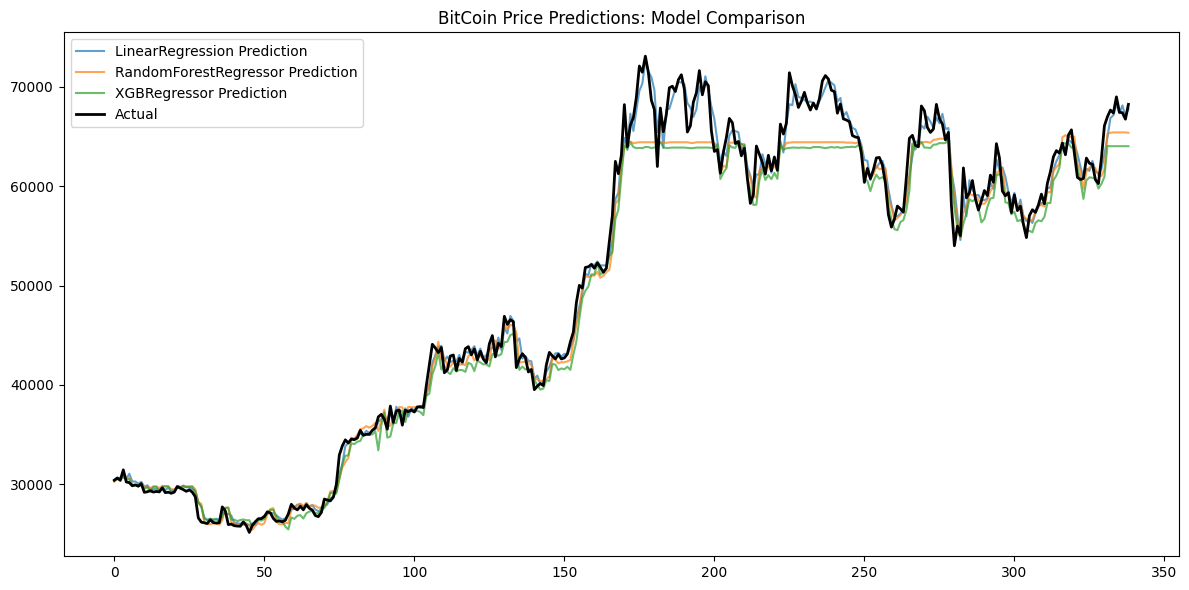

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for name, model in best_models.items():
    preds = model.predict(features_test[search.selected_features])
    plt.plot(preds, label=f"{name} Prediction", alpha=0.7)

plt.plot(target_test.values, label="Actual", color="black", linewidth=2)
plt.title("BitCoin Price Predictions: Model Comparison")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
best_model_lr = grid_search_pipelines["LinearRegression"].best_estimator_

In [46]:
best_model_rf = grid_search_pipelines["RandomForestRegressor"].best_estimator_

In [47]:
best_model_xgb = grid_search_pipelines["XGBRegressor"].best_estimator_

In [ ]:
def feature_importances(best_models, feature_names):
    import numpy as np

    for name, pipeline in best_models.items():
        print(f"\n Selected Feature Importances for {name}:")

        model = pipeline.named_steps["model"]

        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
        elif hasattr(model, "coef_"):
            importances = np.abs(model.coef_)
        else:
            print("  (No importances available)")
            continue

        importance_dict = dict(zip(feature_names, importances))
        sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

        for feature, score in sorted_importances:
            print(f"  {feature}: {score:.4f}")

In [50]:
feature_importances(best_models, search.selected_features)


 Selected Feature Importances for LinearRegression:
  BTC_Close_RollingMean3: 24724.5969
  BTC_Close_Lag1: 8248.9270
  Inflation_Lag1: 263.8305
  Gold_Lag1: 183.7094
  CPI_Lag1: 161.2637
  M2_Lag1: 158.9180
  Nasdaq_Lag1: 79.5717
  TreasuryYield_Lag1: 60.0783
  TEDSpread_Lag1: 4.7173

 Selected Feature Importances for RandomForestRegressor:
  BTC_Close_RollingMean3: 0.8891
  BTC_Close_Lag1: 0.1058
  CPI_Lag1: 0.0027
  M2_Lag1: 0.0011
  Gold_Lag1: 0.0006
  Nasdaq_Lag1: 0.0004
  TreasuryYield_Lag1: 0.0001
  TEDSpread_Lag1: 0.0001
  Inflation_Lag1: 0.0001

 Selected Feature Importances for XGBRegressor:
  BTC_Close_RollingMean3: 0.7495
  BTC_Close_Lag1: 0.1588
  M2_Lag1: 0.0868
  CPI_Lag1: 0.0013
  TreasuryYield_Lag1: 0.0013
  TEDSpread_Lag1: 0.0008
  Nasdaq_Lag1: 0.0006
  Inflation_Lag1: 0.0005
  Gold_Lag1: 0.0005


Finally, we will perform our model evaluation on the train and test sets using the Extra Trees model, which has optimised parameters per the above.

We use the below function, which again came from the Churnometer walkthrough project.

In [63]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def regression_performance(features_train, target_train, features_test, target_test, best_model):
    print("Model Evaluation\n")
    print("* Train Set")
    regression_evaluation(features_train, target_train, best_model)
    print("* Test Set")
    regression_evaluation(features_test, target_test, best_model)

def regression_evaluation(features, target, best_model):
    predictions = best_model.predict(features)
    print('R² Score:', r2_score(target, predictions).round(3))
    print('Mean Absolute Error:', mean_absolute_error(target, predictions).round(3))
    print('Mean Squared Error:', mean_squared_error(target, predictions).round(3))
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(target, predictions)).round(3))
    print("\n")

def regression_evaluation_plots(features_train, target_train, features_test, target_test, best_model, alpha_scatter=0.5):
    predictions_train = best_model.predict(features_train)
    predictions_test = best_model.predict(features_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.scatterplot(x=target_train, y=predictions_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=target_train, y=target_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=target_test, y=predictions_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=target_test, y=target_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predicted")
    axes[1].set_title("Test Set")

    plt.tight_layout()
    plt.show()


We then call the above functions and review the outputs.

Model Evaluation

* Train Set
R² Score: 0.998
Mean Absolute Error: 471.022
Mean Squared Error: 665540.16
Root Mean Squared Error: 815.806


* Test Set
R² Score: 0.995
Mean Absolute Error: 790.163
Mean Squared Error: 1312824.611
Root Mean Squared Error: 1145.786




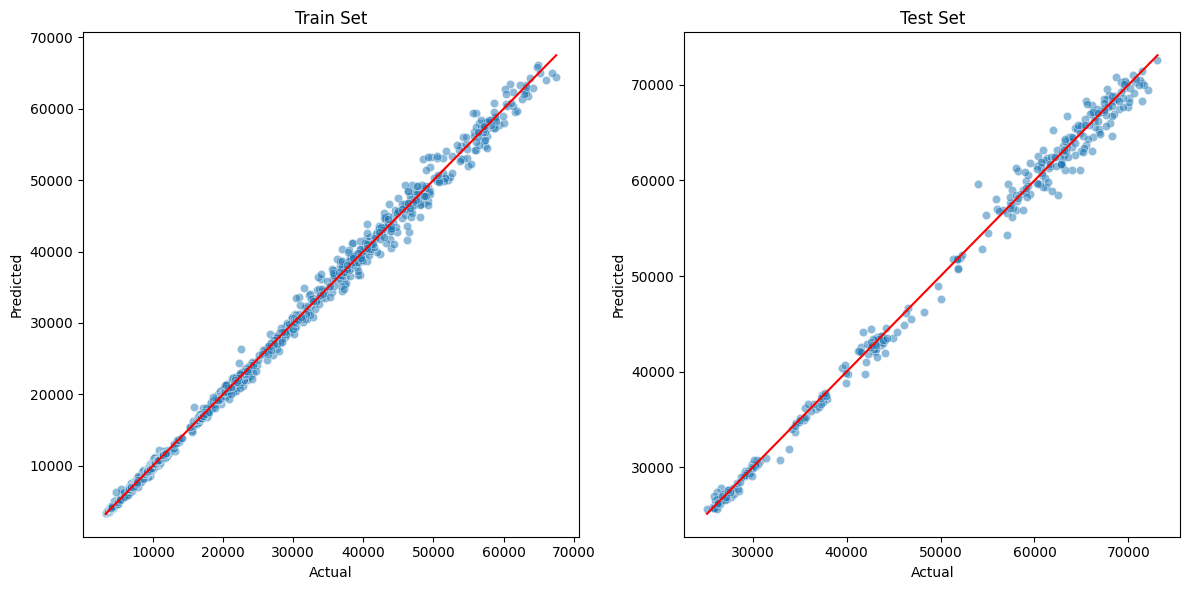

In [64]:
regression_performance(features_train, target_train, features_test, target_test, best_model)
regression_evaluation_plots(features_train, target_train, features_test, target_test, best_model)

# Summary

In this notebook, we determined that Extra Trees was the best model for our data.  

We performed a hyperparameter search to determine the best parameters for use in our model.

We then evaluated our model using both the Train and Test datasets.  The evaluation is as follows:

| Metric | Train Set | Test Set | Interpretation                                                  |
|--------|-----------|--------- |-----------------------------------------------------------------|
|   R2   |   0.996   |   0.991  | Good generalisation.  Explains 99.1% of variance on unseen data |
|   MAE  |   $734    |   $1,099 | Prediction error is in line for both datasets.                  |
|   RMSE |   $1,230  |   $1,949 | Slight increase on test set                                     |
|   MSE  |   1.5M    |   3.8M   | Higher suqared error on the test set as expected                |

Overall, the model confirms that:
* There is minimal overfitting - The Train and Test scores are close
* The accuracy is consistent - MAE and RMSE are low and stable
* The model handles unseen data with confidence

---

# Push files to the repo

We will generate the following files:

* Modeling pipeline
* Regression evaluation plots

Create the ml_pipeline folder in outputs.

In [37]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/predict_btc_price/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

Save the ML Pipeline.

In [38]:
pipeline_btc = grid_search_pipelines["ExtraTreesRegressor"].best_estimator_
pipeline_btc

Pipeline(steps=[('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=20, min_samples_leaf=2,
                                     min_samples_split=5, n_estimators=200,
                                     random_state=0))])

In [39]:
joblib.dump(value=pipeline_btc, filename=f"{file_path}/btc_pipeline.pkl")

['outputs/ml_pipeline/predict_btc_price/v1/btc_pipeline.pkl']

We will also copy our .png files from the data analysis workbook

In [41]:
import os
import shutil
import glob

source_folder = "outputs/datasets/figs/"
destination_folder = "outputs/ml_pipeline/predict_btc_price/v1/"

os.makedirs(destination_folder, exist_ok=True)

image_files = glob.glob(os.path.join(source_folder, "*.png"))

for file_path in image_files:
    shutil.copy(file_path, destination_folder)

